# ML Summer School - Assignment 3

Welcome to Machine Learning Summer School (2018) - Assignment 3. In this assignment, you will make a model that recognises faces! We will also explore Dimensionality Reduction.

In this assignment, we will use `NumPy`, `Matplotlib`, `sklearn`, and `skimage` (an image processing library). Instead of `skimage`, one could instead use other image processing libraries like `OpenCV`, `Pillow`, `scipy.ndimage` etc. But for the sake of uniformity, you have to complete this assignment using `skimage`.

# Importing libraries

In [4]:
%matplotlib inline

import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale, StandardScaler
from sklearn.svm import LinearSVC

# Loading data

## Task 1

The first task is to load the images from data/folder as NumPy array. First manually go through the data, and understand how it is organised.  

`X` should be a NumPy array containing images and `y` should contain the corresponding labels. 

Go through `os.path.join` and `os.listdir` functions. Refer to [`skimage.io.imread`](http://scikit-image.org/docs/dev/api/skimage.io.html#skimage.io.imread) function for loading image.

In [5]:
from skimage import io

X = []
y = []

for sub_dir in os.listdir('data'):
    if not os.path.isdir(os.path.join('data', sub_dir)):
        continue
        
    label = int(sub_dir[1:])
    for file in os.listdir(os.path.join('data', sub_dir)):
        filename = os.path.join('data', sub_dir, file)
        
        # YOUR CODE STARTS HERE
        image =io.imread(filename)
        # YOUR CODE ENDS HERE

        X.append(image)
        y.append(label)
        
X = np.array(X, dtype='float64')
y = np.array(y)

print("X.shape: {}, y.shape: {}".format(X.shape, y.shape))

X.shape: (400, 112, 92), y.shape: (400,)


# Analysing data

Let us first visualise the first image of our dataset.

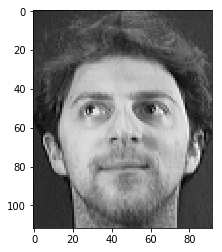

In [6]:
imgplot = plt.imshow(X[0],cmap="gray")
plt.show()

There are 40 subjects in our dataset with 10 images for each of them.

In [7]:
print('Number of images :', X.shape[0])
print('Shape of each image:', X.shape[1], 'x', X.shape[2])

Number of images : 400
Shape of each image: 112 x 92


# Feature Extraction

## Task 2

Currently, `X` is a 3D NumPy array. For each of the 400 images, we have a corresponding 2D matrix storing the pixel values. We will flatten this 2D matrix and use the flattened vector as the feature vector for the image.   

Note that the number of features obtained this way are very large. There are a number of better methods to extract features from images that you will study later on.

Reshape `X` into 400xN, where N is the number of features (112x92).

In [8]:
# YOUR CODE STARTS HERE
X=X.reshape(X.shape[0],10304)
# YOUR CODE ENDS HERE

X.shape

(400, 10304)

# Dimensionality Reduction

We expect that you have gone through the Dimensionality Reduction part of the recommended material. Essentially we use Dimensionality Reduction for, 
1. *Data Visualisation* - We convert the data from a high number of dimensions to two or three, which we can plot. 
2. *Speeding up training* and *reducing memory* required to store the data.

## Data Visualisation

First, we will demonstrate how Dimensionality Reduction is used for Data Visualisation. We will reduce the dimensionality of the data to 2 and plot it. Before applying PCA (one of the Dimensionality Reduction algorithms), we will [standardise](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) the data. For sake of clarity, we will be only using the data corresponding to the first `num_labels` classes.

In [9]:
num_labels = 5
X_sample = X[y <= num_labels]
y_sample = y[y <= num_labels]


In [12]:
X_sample_scaled = scale(X_sample)
#(X_sample_scaled.shape)

## Task 3

Reduce the dimensionality of `X_sample_scaled` to 2 using [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) and assign it to `X_sample_2d`

In [13]:
# YOUR CODE STARTS HERE
X_sample_2d = PCA(n_components=2)
X_sample_2d=X_sample_2d.fit_transform(X_sample_scaled)

X_sample_2d.shape
# YOUR CODE ENDS HERE

X_sample_2d.shape

(50, 2)

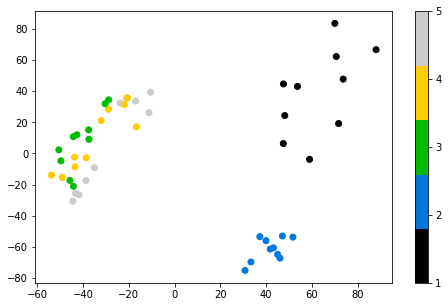

In [14]:
fig = plt.figure(figsize=(8, 5))

# Go through documentation of this method
plt.scatter(X_sample_2d[:,0], X_sample_2d[:,1], c=y_sample, cmap=plt.cm.get_cmap('nipy_spectral', num_labels)) 

cb = plt.colorbar()
loc = np.arange(1, num_labels+1)
cb.set_ticks(loc)

We can clearly see PCA has projected the highly dimensional dataset into 2 dimensions, which we can see on plotting look clustered. 

Although this data visualisation is not very useful for supervised learning tasks, they prove useful for unsupervised learning tasks.   

## Speeding up training and reducing memory 

The other two applications of Dimensionality reduction are, speeding up training and reducing memory required to store the data. We will start by investigating the memory required.

In [15]:
print("Memory used by X: {:.2f}MB".format(X.nbytes / 1024 / 1024))

Memory used by X: 31.45MB


In this case, because of low resolution of images and less data, the memory used in storing data is already quite low. It doesn't make sense to use PCA for this purpose.

### Splitting the dataset

In [16]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### Standardising the Dataset

> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data.

Standardising the dataset is not only [helpful for training](http://scikit-learn.org/stable/modules/preprocessing.html) machine learning models but is also a requirement before applying PCA. We will standardise all three `X_train`, `X_val` and `X_test`. 

In [17]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

### Training and Hyperparameter Tuning 

#### Without Dimensionality reduction

We will be using [time magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-time) in Jupyter Notebook to measure the time taken in fitting the model. Read up about other useful magic commands like `timeit` `prun`, `lprun` on the web page linked before.

In [18]:
clf = LinearSVC(C=.001)
%time clf = clf.fit(X_train_scaled, y_train)

print("Training accuracy: {:.4f}, Val Accuracy: {:.4f}".format(clf.score(X_train_scaled, y_train), clf.score(X_val_scaled, y_val)))

CPU times: user 45.1 s, sys: 49.6 ms, total: 45.2 s
Wall time: 45.2 s
Training accuracy: 1.0000, Val Accuracy: 0.8167


In [19]:
clf = LogisticRegression(C=.001)
%time clf = clf.fit(X_train_scaled, y_train)

print("Training accuracy: {:.4f}, Val Accuracy: {:.4f}".format(clf.score(X_train_scaled, y_train), clf.score(X_val_scaled, y_val)))

CPU times: user 1min, sys: 1.6 s, total: 1min 2s
Wall time: 31.6 s
Training accuracy: 1.0000, Val Accuracy: 0.8167


#### With Dimensionality reduction

Clearly, the time taken to train the model is considerably high. It is infeasible to perform hyperparameter tuning when training the model takes so much time. In some cases when the dataset is even bigger, we might not be able to even train the model with the computing resources in hand. PCA becomes essential to speed up training.  

## Task 4

Make an object of `PCA` class named `pca` so that 99% of variance is preserved. Refer to the documentation of `PCA` class.  

In [20]:
# YOUR CODE STARTS HERE
pca=PCA(0.99)
# YOUR CODE ENDS HERE

In [21]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

print("Dimensionality reduced to:", pca.n_components_)

Dimensionality reduced to: 236


In [22]:
clf = LogisticRegression(C=.01)
%time clf = clf.fit(X_train_pca, y_train)

print("Training accuracy: {:.4f}, Val Accuracy: {:.4f}".format(clf.score(X_train_pca, y_train), clf.score(X_val_pca, y_val)))

CPU times: user 1.39 s, sys: 7.88 ms, total: 1.39 s
Wall time: 1.33 s
Training accuracy: 1.0000, Val Accuracy: 0.8000


In [23]:
clf = LinearSVC(C=.001)
%time clf = clf.fit(X_train_pca, y_train)

print("Training accuracy: {:.4f}, Val Accuracy: {:.4f}".format(clf.score(X_train_pca, y_train), clf.score(X_val_pca, y_val)))

CPU times: user 1.76 s, sys: 21 µs, total: 1.76 s
Wall time: 1.71 s
Training accuracy: 1.0000, Val Accuracy: 0.8000


PCA reduced the training time considerably with negligible loss in accuracy. Though the loss in accuracy might not justified in this case (if training the model didn't take much time for you), it might be necessary in some cases. 

# Testing 

We now test our model on the testing data. 

In [24]:
# Couple of utilities functions
def plot_gallery(images, titles, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        fig = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())
    plt.tight_layout()
    plt.show()
        
def titles(y_pred, y_test):
    for i in range(y_pred.shape[0]):
        yield 'predicted: {0}\ntrue: {1}'.format(y_pred[i], y_test[i])

In [25]:
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

In [26]:
y_pred = clf.predict(X_test_pca)
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))

Accuracy score: 0.9167


# Predictions

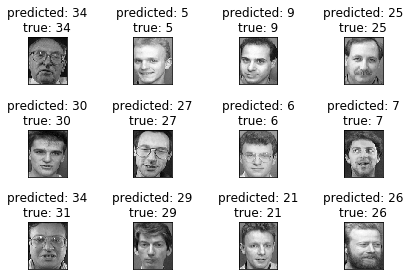

In [27]:
prediction_titles = list(titles(y_pred, y_test))
plot_gallery(X_test.reshape(-1, 112, 92), prediction_titles)

Congratulations you have built a face recogniser! You also explored the application of dimensionality reduction in this assignment.   

If you have sincerely completed the material and the assignments of last two sections, you have gained sufficient knowledge to solve real life supervised Machine Learning problems. You can now go explore the world of competitive machine learning on [Kaggle.com](www.kaggle.com).